## Needed Imports

In [193]:
import pymssql
import pandas as pd
from config import server,username, password,database
import seaborn as sns
import matplotlib.pyplot as plt
import heapq
import warnings

---
## Pulls needed data from DataBase

In [194]:
# pull queies from SQL database
try:
    conn = pymssql.connect(server,username, password,database)

    cursor = conn.cursor()
    query = f"""
    SELECT C.Character_Name, Cl.Class_Name, 
    S.HP, S.Str, S.Mag, S.Dex, S.Spd, S.Def, S.Res, S.Lck, S.Bld, S.Rating
    FROM Stats_to_Character AS SC
    INNER JOIN [Character] AS C ON SC.Character_ID = C.Character_ID
    INNER JOIN Class AS Cl ON SC.Class_ID = Cl.Class_ID
    INNER JOIN Stats AS S ON SC.Stats_ID = S.Stats_ID
    """
    Fire_Emblem = pd.read_sql(query, conn)
except Exception as e:
    print(e)
Fire_Emblem.head()

,Character_Name,Class_Name,HP,Str,Mag,Dex,Spd,Def,Res,Lck,Bld,Rating
0,Alear,Dragon Child,70,45,20,55,65,50,35,30,10,380
1,Alear,Divine Dragon,70,45,20,55,65,55,40,35,10,395
2,Alear,Sword Fighter,70,45,20,60,70,40,40,35,5,385
3,Alear,Swordmaster,70,45,20,60,70,40,40,40,5,390
4,Alear,Hero,75,50,20,55,65,40,35,40,5,385


### Get a idea of the top character class combos based on ratings

In [195]:
Fire_Emblem.sort_values("Rating", ascending = False).head(20)

,Character_Name,Class_Name,HP,Str,Mag,Dex,Spd,Def,Res,Lck,Bld,Rating
1157,Mauvier,Great Knight,90,50,40,55,35,75,55,20,20,440
1156,Mauvier,General,95,55,40,50,35,80,45,15,25,440
1146,Mauvier,Royal Knight,75,45,55,55,50,55,65,25,15,440
1162,Mauvier,Wolf Knight,80,40,40,55,55,55,65,35,15,440
1161,Mauvier,Paladin,85,50,40,50,50,65,60,25,15,440
1173,Mauvier,Wyvern Knight,90,55,40,50,40,70,50,20,20,435
1152,Mauvier,Bow Knight,80,45,40,60,55,50,60,30,15,435
1151,Mauvier,Sniper,85,50,40,70,45,60,45,25,15,435
1149,Mauvier,Warrior,95,55,40,50,50,60,50,15,20,435
1148,Mauvier,Berserker,100,65,40,45,45,55,45,15,25,435


---
## Create a Heat Map of Character Class combos to get general outline of data

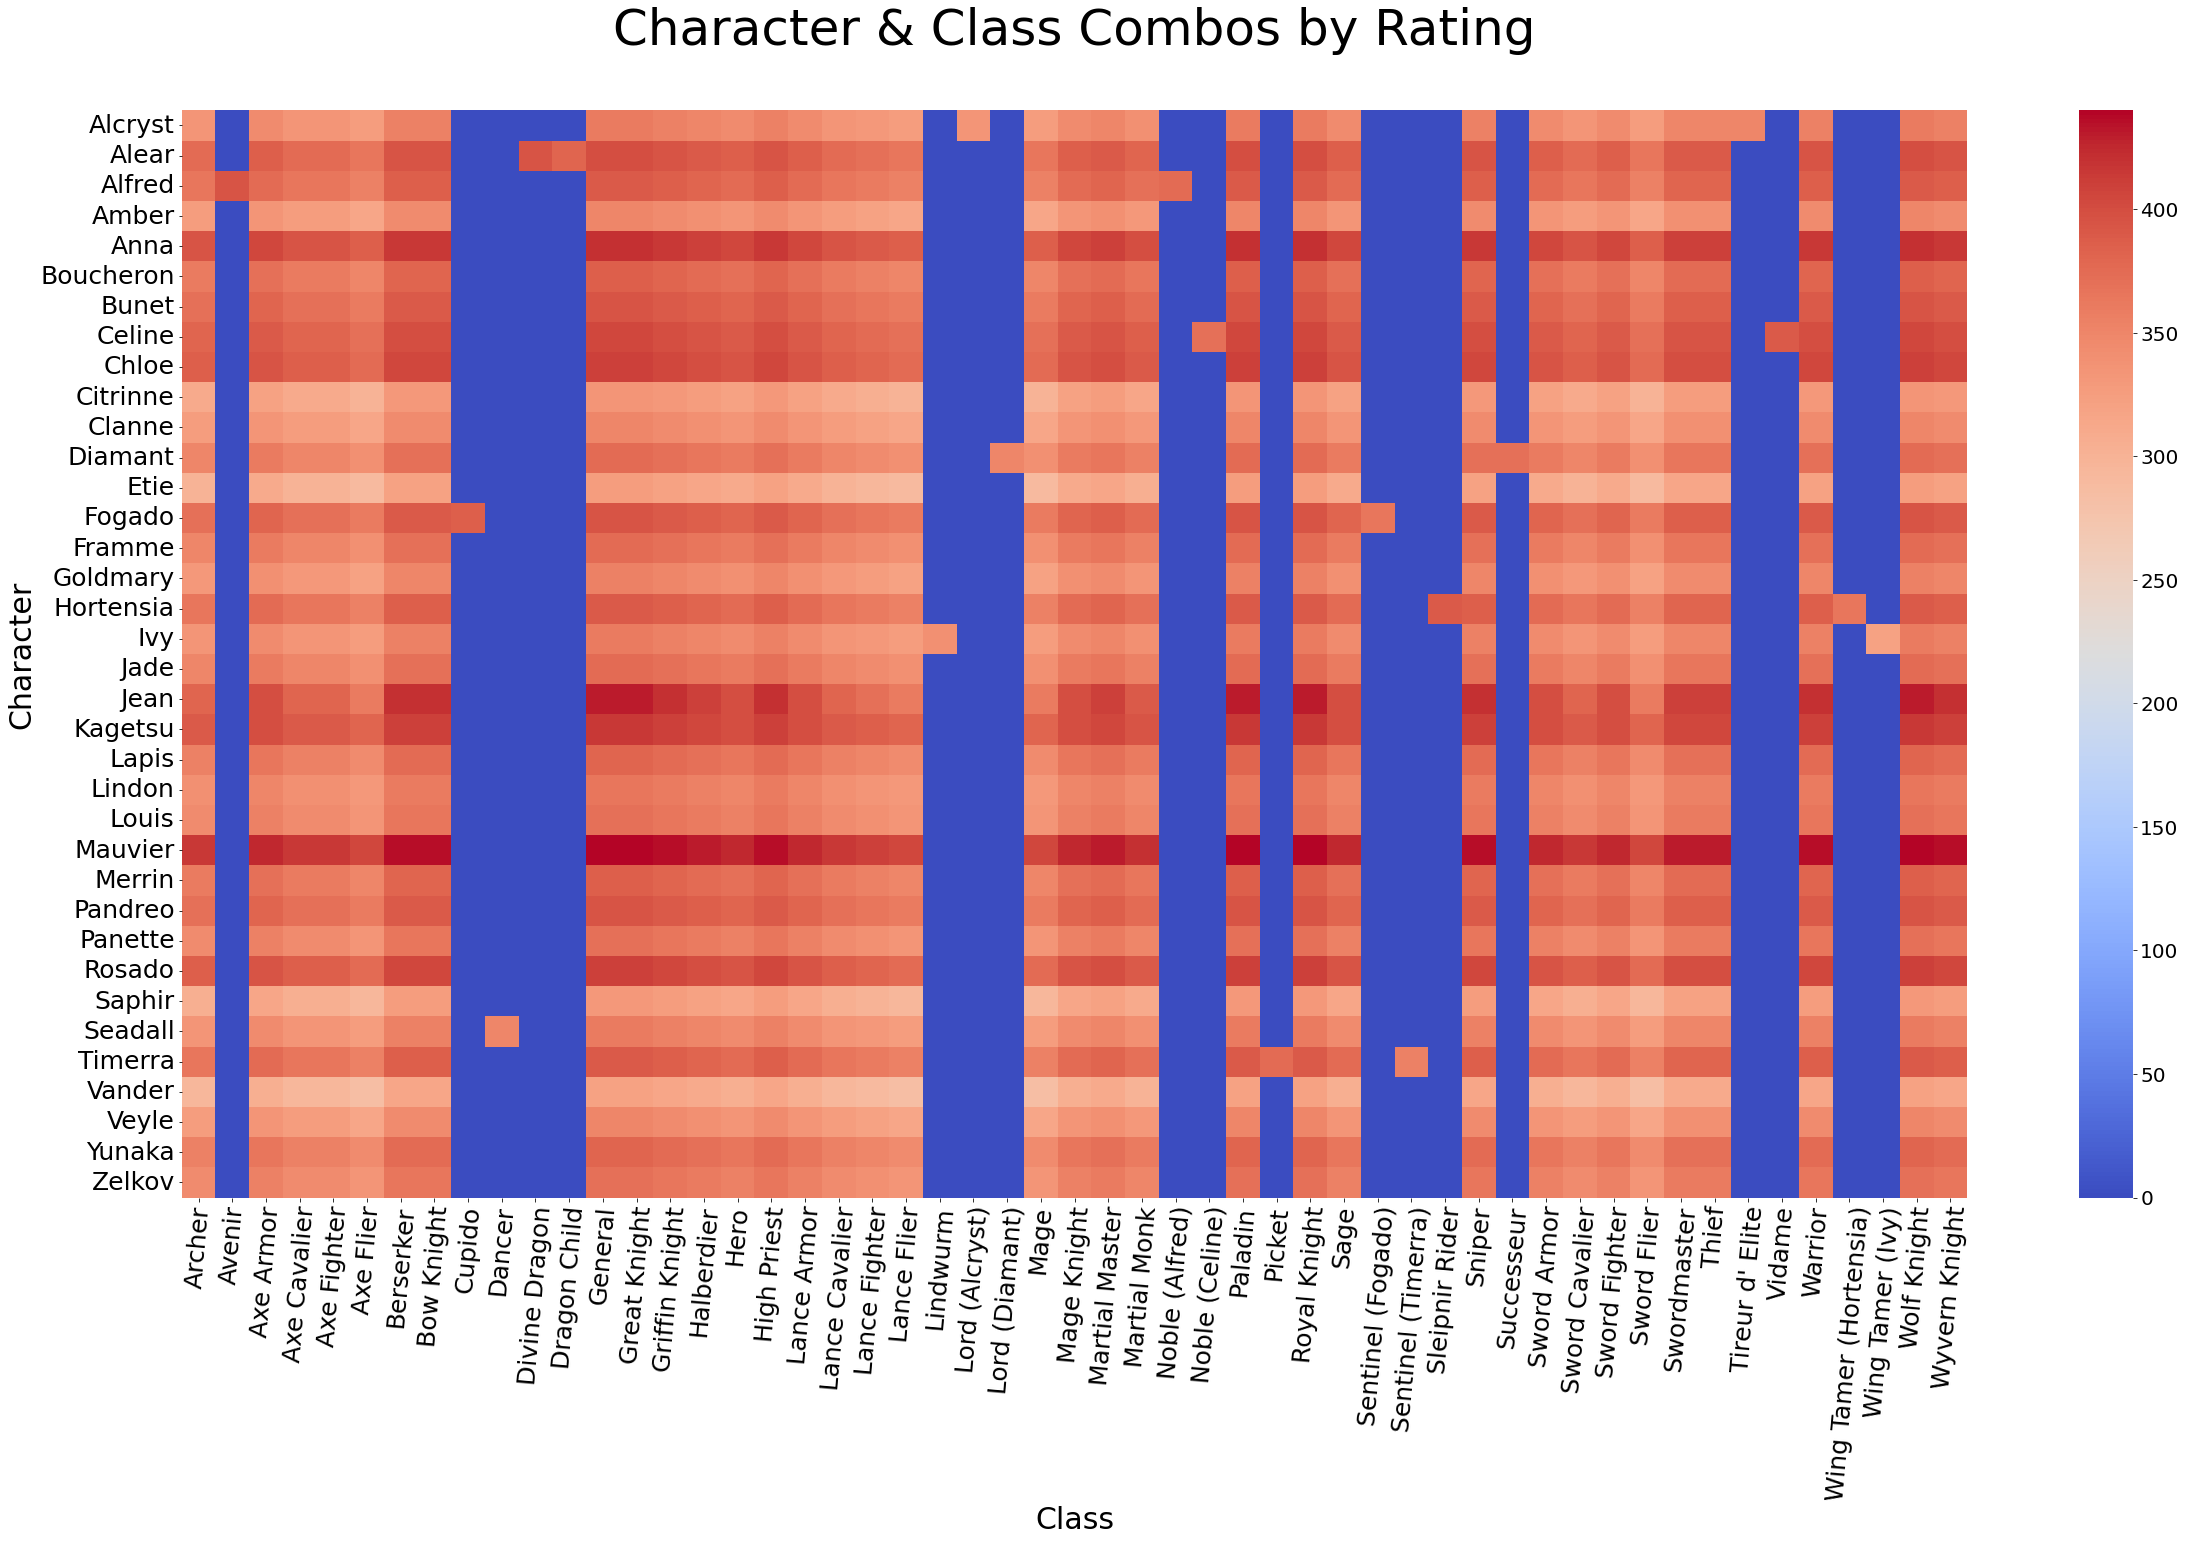

In [196]:
intensity_interest = 'Rating'
Fire_Emblem_class_to_character = Fire_Emblem[["Class_Name","Character_Name",f"{intensity_interest}"]].pivot("Character_Name", "Class_Name").fillna(0)

fig, ax = plt.subplots(figsize=(40,20)) 
hm = sns.heatmap(Fire_Emblem_class_to_character, ax = ax, cmap = "coolwarm")

# Remove the word "Rating" from the class labels
hm.set_xticklabels([label.get_text().replace('Rating-', '') for label in hm.get_xticklabels()], rotation=85)

hm.set_title("Character & Class Combos by Rating\n", size = 50)
hm.set_xlabel("Class", size = 30)
hm.set_ylabel("Character", size = 30)
hm.tick_params(axis='x', labelsize=25)
hm.tick_params(axis='y', labelsize=25)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=20)

plt.show()

---
## Create Algorithimic approach to find best team based on stats prefrence

### Create Initial Teams based on Backtracking Algorithm
The `best_team_interest` function is an algorithm to find the top team combinations based on a specific interest, given a dataframe of character and class combinations, and a desired team size.

1. The function first calculates the mean of the specified interest column in the dataframe.<br><br>
2. It filters the dataframe to only include rows where the interest value is greater than the mean.<br><br>
3. It converts the filtered dataframe to a list of lists and sorts the list in descending order based on the interest value.<br><br>
4. It initializes an empty list to hold the top team combinations, and a variable to hold the maximum interest value found so far.<br><br>
5. The function defines a recursive helper function called `backtrack` to generate all possible team combinations.<br><br>
6. The `backtrack` function takes as parameters the current team, a dictionary of the team members (with class as key and character as value), the current sum of the interest values for the team, and the index to start searching for new team members.<br><br>
7. The `backtrack` function first checks if the current team is of the desired size. If it is, it compares the team's interest value sum to the maximum value found so far. If it's greater, it replaces the list of top teams with a list containing only the current team and updates the maximum interest value found so far. If it's equal to the current maximum, it adds the current team to the list of top teams.<br><br>
8. If the current team is not of the desired size, the function checks if there are enough team members left to form a complete team. If not, it returns.<br><br>
9. The function then calculates an upper bound for the remaining interest value sum based on the current interest value sum and the interest values of the remaining possible team members. If this upper bound is less than or equal to the current maximum, it returns.<br><br>
10. If the upper bound is greater than the current maximum, the function loops through the remaining possible team members and checks if the member's class or character is already in the team dictionary. If it is, the member is skipped. Otherwise, the function creates a new team with the member, updates the team dictionary, and updates the current interest value sum. It then calls `backtrack` recursively with the new team, dictionary, and interest value sum, starting the search for new team members at the next index.<br><br>
11. Finally, the function calls `backtrack` with an empty team, an empty dictionary, an interest value sum of 0, and a starting index of 0.<br><br>
12. The function returns the list of top team combinations found.

In [244]:
def best_team_interest(df, interest, team_size, repeat_classes = False):
    mean_ = df[f'{interest}'].mean()
    df = df.loc[df[f'{interest}'] > mean_, ["Class_Name", "Character_Name", f"{interest}"]]
    lists = df.values.tolist()
    lists.sort(key=lambda x: x[2], reverse=True)
    top_teams = []
    max_sum = 0
    
    def backtrack(team, team_dict, combo_sum, start, repeat_classes = False):
        nonlocal top_teams, max_sum
        if len(team) == team_size:
            if combo_sum > max_sum:
                top_teams = [team]
                max_sum = combo_sum
            elif combo_sum == max_sum:
                heapq.heappush(top_teams, team)
            return
        if len(lists) - start < team_size - len(team):
            return
        upper_bound = combo_sum + sum([x[2] for x in lists[start:start+team_size-len(team)]])
        if upper_bound <= max_sum:
            return
        team_names = [i[1] for i in team]
        for i in range(start, len(lists)):
            member = lists[i]
            if(repeat_classes):
                if member[1] in team_names:
                    continue
                new_team = team + [member]
                new_dict = dict(team_dict)
                new_dict[member[0]] = member[1]
                new_sum = combo_sum + member[2]
                backtrack(new_team, new_dict, new_sum, i + 1, repeat_classes = repeat_classes)
            else:
                if member[0] in team_dict or member[1] in team_names:
                    continue
                new_team = team + [member]
                new_dict = dict(team_dict)
                new_dict[member[0]] = member[1]
                new_sum = combo_sum + member[2]
                backtrack(new_team, new_dict, new_sum, i + 1, repeat_classes = repeat_classes)
            
    backtrack([], {}, 0, 0, repeat_classes = repeat_classes)
    return top_teams

### Increase members of base teams created and reduce top teams based on user interests
This code implements an algorithm to find the best teams of a desired size based on a given interest in a data frame containing information on classes, characters, and their respective interest values. The algorithm starts by filtering the data frame to include only rows where the interest value is greater than the mean interest value. The rows are then sorted by interest value in descending order.

The algorithm takes in the desired team size, the interest of the team, and potentially a list of already known best teams of a smaller size. If the desired team size is less than 6, the algorithm simply returns the best team of that size using the `best_team_interest()` function. If the desired team size is 6 or greater, the `best_teams_known` parameter must be provided, as this parameter is used to determine which roles and characters are already filled by the known best teams.

The algorithm then creates a set of roles and characters that are already filled by the known best teams. It creates a heap of remaining potential team members sorted by interest value in descending order. The algorithm then iterates through each known best team, creates a copy of the team, and starts filling in the remaining positions with potential team members from the heap until the desired team size is reached. If a team is filled with potential members, the sum of their interest values is compared with the maximum sum of interest values found so far, and if it is greater or equal, the team is added to a list of top teams.

The algorithm returns a list of the best teams found.

In [245]:
def best_team_reductions(df, interest, desired_size, best_teams_known=None, repeat_classes = False):
    df = df[["Class_Name", "Character_Name", f"{interest}"]]
    lists = df.values.tolist()
    lists.sort(key=lambda x: x[2], reverse=True)
    
    if best_teams_known is None:
        if desired_size >= 6:
            best_teams_known = best_team_interest(df, interest, 6, repeat_classes)
        else:
            return best_team_interest(df, interest, desired_size, repeat_classes)
    
    top_teams = []
    max_sum = 0
    
    for team in best_teams_known:
        team_potential = team.copy()
        roles_set = set([i[0] for i in team_potential])
        characters_set = set([i[1] for i in team_potential])
        if(repeat_classes):
            potential = [person for person in lists if person[1] not in characters_set]
        else:
            potential = [person for person in lists if person[0] not in roles_set and person[1] not in characters_set]
        potential.sort(key=lambda x: x[2], reverse=True)
        
        while len(team_potential) < desired_size and potential:
            person = potential.pop(0)
            if(repeat_classes):
                if person[1] not in characters_set:
                    team_potential.append(person)
                    roles_set.add(person[0])
                    characters_set.add(person[1])
            else:
                if person[0] not in roles_set and person[1] not in characters_set:
                    team_potential.append(person)
                    roles_set.add(person[0])
                    characters_set.add(person[1])

        if len(team_potential) == desired_size:
            sum_ = sum([i[2] for i in team_potential])
            if sum_ >= max_sum:
                top_teams.append(team_potential)
                max_sum = sum_
    
    return top_teams

### Find the single best team for the user based on their desired prefrence in a team
The `selected_team_prefrence` function is a Python algorithm that takes in three parameters: `team_size`, `df`, and `prefrence`. It first checks if the team_size exceeds the maximum team size of 20, and if so, it returns a message indicating the error.

Then, the function checks if a preference is specified. If it is, it verifies whether it is a valid preference and returns an error message if it is not. If no preference is specified, it calls another function `best_team_reductions` to calculate the best team combinations based on the `"Rating"` column of the `df` DataFrame.

Next, the function constructs a list of dictionaries `team_data`, where each dictionary contains total values for each statistic for a particular team. The team data is calculated by iterating through the best team combinations and selecting the corresponding rows from the `df` DataFrame.

After that, the function selects the preferred team based on the preference specified or the "Rating" column if no preference was provided. It then constructs a new DataFrame `df_team` that contains only the members of the selected team.

Finally, the function calculates the total values of the statistics for the selected team and constructs a DataFrame `totals_df` containing this data, which is returned by the function.

In [246]:
def selected_team_prefrence(team_size, df = Fire_Emblem, prefrence = None, repeat_classes = False):
    if(team_size > 20):
        return print(f"Team size of {team_size} exceeds the max team size of 20.")
    prefs = ["HP", "Str", "Mag", "Dex", "Spd", "Def", "Res", "Lck", "Bld", "Rating"]
    if(prefrence is not None and prefrence not in prefs):
            return print(f"Inputted prefrence not valid.\nPrefrence input must be one of the following if entered: {', '.join(prefs)}")
    elif(prefrence == None):
        best_teams = best_team_reductions(df, "Rating", team_size, repeat_classes = repeat_classes)
    else:
        best_teams = best_team_reductions(df, f"{prefrence}", team_size, repeat_classes = repeat_classes)
    team_data = []
    for team in best_teams:
        df_bare_bones = df.sample(0)
        for member in team:
            member_df = df[df["Character_Name"] == member[1]][df["Class_Name"] == member[0]]
            df_bare_bones = pd.concat([df_bare_bones, member_df], axis=0)
        df_bare_bones = df_bare_bones.reset_index(drop=True)
        totals_data = {'Character_Name':["Total"], 'Class_Name':["Total"], 'HP':[df_bare_bones["HP"].sum()], 'Str':[df_bare_bones["Str"].sum()],
                   'Mag': [df_bare_bones["Mag"].sum()], 'Dex':[df_bare_bones["Dex"].sum()], 'Spd':[df_bare_bones["Spd"].sum()],
                   'Def':[df_bare_bones["Def"].sum()], 'Res':[df_bare_bones["Res"].sum()], 'Lck':[df_bare_bones["Lck"].sum()], 
                   'Bld':[df_bare_bones["Bld"].sum()], 'Rating':[df_bare_bones["Rating"].sum()]}
        team_data.append(totals_data)

    if(prefrence == None):
        prefrence_ranks = [team["Rating"] for team in team_data]
    else:
        prefrence_ranks = [team[f"{prefrence}"] for team in team_data]
    team_index = prefrence_ranks.index(max(prefrence_ranks))
    wanted_team = best_teams[team_index]
    df_team = df.sample(0)
    for member in wanted_team:
        member_df = df[df["Character_Name"] == member[1]][df["Class_Name"] == member[0]]
        df_team = pd.concat([df_team, member_df], axis=0)
    df_team = df_team.reset_index(drop=True)
    totals_data = {'Character_Name':["--","Total"], 'Class_Name':["--",""], 'HP':["--",df_team["HP"].sum()], 'Str':["--",df_team["Str"].sum()],
                'Mag': ["--",df_team["Mag"].sum()], 'Dex':["--",df_team["Dex"].sum()], 'Spd':["--",df_team["Spd"].sum()],
                'Def':["--",df_team["Def"].sum()], 'Res':["--",df_team["Res"].sum()], 'Lck':["--",df_team["Lck"].sum()], 
                'Bld':["--",df_team["Bld"].sum()], 'Rating':["--",df_team["Rating"].sum()]}
    totals_df = pd.DataFrame(totals_data)
    df_team = pd.concat([df_team, totals_df], axis=0)
    return df_team

---
# Team Creator

To use the code, you need to input two variables: `desired_team_size` and `prefrence_for_team`.

- `desired_team_size` should be a number between `1` and `20`, which represents the desired team size.

- `prefrence_for_team` is an optional input, which should be set to one of the following options: `"HP"`, `"Str"`, `"Mag"`, `"Dex"`, `"Spd"`, `"Def"`, `"Res"`, `"Lck"`, `"Bld"`, or `"Rating"`. If you leave it blank, the function will default to using `"Rating"` as the preference. `"Rating"` is the best prefrence for achieving a overall balanced team.

- `allow_class_repeats` is an optional input, which should be set to one of the following options: True or False. If True, the resulting dataframe will allow for classes to be repeated in a team. This may result in the team's overall `prefrence_for_team` to be a greater value then when `allow_class_repeats` is False, however, is may cause the team to be less balanced. When the `allow_class_repeats` is False, no classes can repeat in the final dataframe creating the resulting team. False is the default value of this function.

Once you have set these variables, you can call the function selected_team_prefrence with the desired team size and preference as arguments. The function will return a pandas dataframe with information on the selected team.

The overall time complexity of the `selected_team_prefrence` function is **O(N * C(TeamSize, N) + K * (M + TeamSize))**, where N is the number of rows in the input dataframe, K is the number of best teams returned by `best_team_reductions`, M is the length of the `potential` list, and TeamSize is the desired size of the team. In practice, the time complexity will depend on the input data and the values of the function parameters, but this provides an upper bound on the possible complexity. This will result in the `selected_team_prefrence` function taking a max of 2 minutes give or take for certain inputs.

In [257]:
# Team Size Options: 1 - 20
#   if team size is greater or equal to 8, selected_team_prefrence function will take over 8 minutes to run
desired_team_size = 8

# Prefrences Options: "HP", "Str", "Mag", "Dex", "Spd", "Def", "Res", "Lck", "Bld", "Rating"
prefrence_for_team = "Rating"

# Class Repeat Prefrence: True or False
allow_class_repeats = False

# returns pandas dataframe with information on wanted team
# function without prefrence format - selected_team_prefrence(desired_team_size)
warnings.filterwarnings('ignore')
wanted_team_df = selected_team_prefrence(desired_team_size, prefrence=prefrence_for_team, repeat_classes = allow_class_repeats)

wanted_team_df

,Character_Name,Class_Name,HP,Str,Mag,Dex,Spd,Def,Res,Lck,Bld,Rating
0,Mauvier,General,95,55,40,50,35,80,45,15,25,440
1,Jean,Great Knight,90,50,20,65,40,75,40,35,15,430
2,Anna,Paladin,70,30,50,60,65,35,50,55,5,420
3,Kagetsu,Royal Knight,65,40,30,65,65,45,45,50,10,415
4,Chloe,Wolf Knight,85,30,35,55,75,35,45,45,5,410
5,Rosado,Berserker,105,75,25,45,55,35,30,20,15,405
6,Celine,Warrior,75,55,25,40,60,40,45,50,10,400
7,Alear,Divine Dragon,70,45,20,55,65,55,40,35,10,395
0,--,--,--,--,--,--,--,--,--,--,--,--
1,Total,,655,380,245,435,460,400,340,305,95,3315


---